## Short Term Wind Climate 
**5. Filter data: (report page 30 - 33)**
- Outliers in wind speed and direction 
- Datagaps: Done in 'Overwiev'

**4. Interpolate:**
- Interpolate to the  one height of interest (= 150 meters for current turbine)

**7. Compare the both met masts:**
- Scatterplot: windspeed 150 m height mast one against windspeed 150m height mast 2 
- Same with the wind direction 
- Correlate with r^2 - linear correlation for both

**8. Short Term Wind Analysis**
- Mean, stdv of monthly and annual ws 
- Wind roses 
- Select parameters for Weibull model 
- Plot Weibull model 
- Diurnal profile of wind speed (blue) and wind direction (red) at HKW at 100 m MSL
- Monthly profile of the wind speed 
- Power curve of such a turbine
- Annual production of one turbine
- Annual production of wind farm


#### Import Libraries  

In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import xarray as xr
import pandas as pd
import os
import netCDF4 as nc
from netCDF4 import Dataset
import numpy as np

#### File Paths

In [2]:
# Data Paths
bouy6_path = 'data/measurements/2023-11-06_Buoy6_BSH_N-9.nc'
bouy2_path = 'data/measurements/2023-11-09_Buoy2_BSH_N-9.nc'
era5_path = 'data/reanalysis/'
turbines_existing_path = 'data/turbine-info/coordinates/existing/'
turbines_planned_future_path = 'data/turbine-info/coordinates/planned_future/'
turbines_planned_in_operation_before_2030_path = 'data/turbine-info/coordinates/planned_in_operation_before_2030/'
turbines_planned_netherlands_path = 'data/turbine-info/coordinates/planned_netherlands/'
turbines_area_of_interest_path = 'data/turbine-info/coordinates/area_of_interest/'
shapefiles_DEU_path = 'data/shapefiles/DEU/*'
shapefiles_DNK_path = 'data/shapefiles/DNK/*'
shapefiles_NLD_path = 'data/shapefiles/NLD/*'
turbine_power_curves_path = 'data/turbine-info/power_curves/'

From 'Overview' we decided to work with: buoy_6_measured and buoy_2_correlated_with_6 bcs. buoy 2 had a lot of data gaps (not a complete year measured)

In [3]:
#Load the datafiles in xr and netcdf 

xrbuoy6 = xr.open_dataset(bouy6_path)
xrbuoy2 = xr.open_dataset(bouy2_path)

buoy2_file = Dataset(bouy2_path)
buoy6_file = Dataset(bouy6_path)

In [4]:
xrbuoy2

<xarray.Dataset> Size: 541kB
Dimensions:    (longitude: 1, latitude: 1, time: 67680, height: 6)
Coordinates:
  * longitude  (longitude) float32 4B 5.792
  * latitude   (latitude) float32 4B 54.5
  * time       (time) datetime64[ns] 541kB 2022-03-03 ... 2023-06-15T23:49:59...
  * height     (height) int32 24B 14 41 94 140 200 250
Data variables:
    *empty*
Attributes:
    long_name:    Data measured by the sensors mounted on the Fraunhofer IWES...
    description:  BSH N-9 Fraunhofer IWES WLBZ_2 data from the period 2022-03...
    disclaimer:   The use of the data is in the sole responsibility of the user.

In [5]:
xrbuoy6

<xarray.Dataset> Size: 458kB
Dimensions:    (longitude: 1, latitude: 1, time: 57196, height: 6)
Coordinates:
  * longitude  (longitude) float32 4B 5.521
  * latitude   (latitude) float32 4B 54.4
  * time       (time) datetime64[ns] 458kB 2022-03-03 ... 2023-04-04T04:30:00
  * height     (height) int32 24B 14 42 94 140 200 250
Data variables:
    *empty*
Attributes:
    long_name:    Data measured by the sensors mounted on the Fraunhofer IWES...
    description:  BSH N-9 Fraunhofer IWES WLBZ_6 data from the period 2022-03...
    disclaimer:   The use of the data is in the sole responsibility of the user.

In [6]:
# select the data of interest for now
time2 = xrbuoy2.variables['time'][:]
windspeed2 = buoy2_file.groups['ZX_LIDAR_WLBZ_6_MCP'].variables['wind_speed'][:]
winddirection_buoy_2 = buoy2_file.groups['ZX_LIDAR_WLBZ_6_MCP'].variables['wind_from_direction'][:]

In [7]:
time6 = xrbuoy6.variables['time'][:]
windspeed6 = buoy6_file.groups['ZX_LIDAR_WLBZ_6'].variables['wind_speed'][:]
winddirection_buoy_6 = buoy6_file.groups['ZX_LIDAR_WLBZ_6'].variables['wind_from_direction'][:]

In [8]:
#Filter all NaN values consistent! 
def filter_nan_values(arr):
    return arr[~np.isnan(arr)]

def filter_time_nan(time_variable):
    valid_time_rows = time_variable.astype('str') != 'NaT'
    filtered_time_variable = time_variable[valid_time_rows]
    return filtered_time_variable

def filter_and_align_data(time_var, wind_speed_var, wind_direction_var):
    valid_indices = ~np.isnan(time_var) & ~np.isnan(wind_speed_var) & ~np.isnan(wind_direction_var)
    filtered_time = time_var[valid_indices]
    filtered_wind_speed = wind_speed_var[valid_indices]
    filtered_wind_direction = wind_direction_var[valid_indices]
    return filtered_time, filtered_wind_speed, filtered_wind_direction

def process_wind_data_nan(time, winddirection, windspeed):
    # Initialize empty lists to store the results
    wd_nanfilters = []
    ws_nanfilters = []
    time_filtered = []
  

    # Loop over the range of indices and filter NaN values
    for i in range(0, 6):
        t, ws, wd = filter_and_align_data(time, windspeed[:, 0, 0, i], winddirection[:, 0, 0, i])
        time_filtered.append(t)
        ws_nanfilters.append(ws)
        wd_nanfilters.append(wd)


    # #Print the length of the original arrays
    # print(f'The original length of time array: {len(time)}')
    # print(f'The original length of winddirection array: {len(winddirection)}')
    # print(f'The original length of windspeed array: {len(windspeed)}')

    # # Print the length of the filtered arrays and absolute filtered values
    # for i, (filtered_time, filtered_ws, filtered_wd) in enumerate(zip(time_filtered, ws_nanfilters, wd_nanfilters)):
    #     print(f'The length of timefiltered{i+1} array: {len(filtered_time)}')
    #     print(f'The length of ws_nanfilter{i+1} array: {len(filtered_ws)}')
    #     print(f'The length of wd_nanfilter{i+1} array: {len(filtered_wd)}')
    
    return  time_filtered, wd_nanfilters, ws_nanfilters

time2_filtered, wd2_nanfilters, ws2_nanfilters = process_wind_data_nan(time2, winddirection_buoy_2, windspeed2)
time6_filtered, wd6_nanfilters, ws6_nanfilters = process_wind_data_nan(time6, winddirection_buoy_6, windspeed6)

In [9]:
def interpolate_arrays(array1, array2, height1, height2, target_height):

    min_length = min(len(array1), len(array2))
    array1 = array1[:min_length]
    array2 = array2[:min_length]

    # Calculate the interpolation factor
    factor = (target_height - height1) / (height2 - height1) #factor = (x-x1)/(x2-x1)
    # Perform the interpolation
    interpolated_array = array1 + factor * (array2 - array1)

    return interpolated_array

ws6_150m = interpolate_arrays(ws6_nanfilters[3], ws6_nanfilters[4], 140, 200, 150)
wd6_150m = interpolate_arrays(wd6_nanfilters[3], wd6_nanfilters[4], 140,200, 150 )
ws2_150m = interpolate_arrays(ws2_nanfilters[3], ws2_nanfilters[4],  140,200, 150 )
wd2_150m = interpolate_arrays(wd2_nanfilters[3], wd2_nanfilters[4],  140,200, 150 )

#test if they have the same shape 
print(ws6_150m.shape)
print(wd6_150m.shape)
print(time6_filtered[4].shape)
print()
print(ws2_150m.shape)
print(wd2_150m.shape)
print(time2_filtered[4].shape)


(55199,)
(55199,)
(55199,)

(55130,)
(55130,)
(55130,)


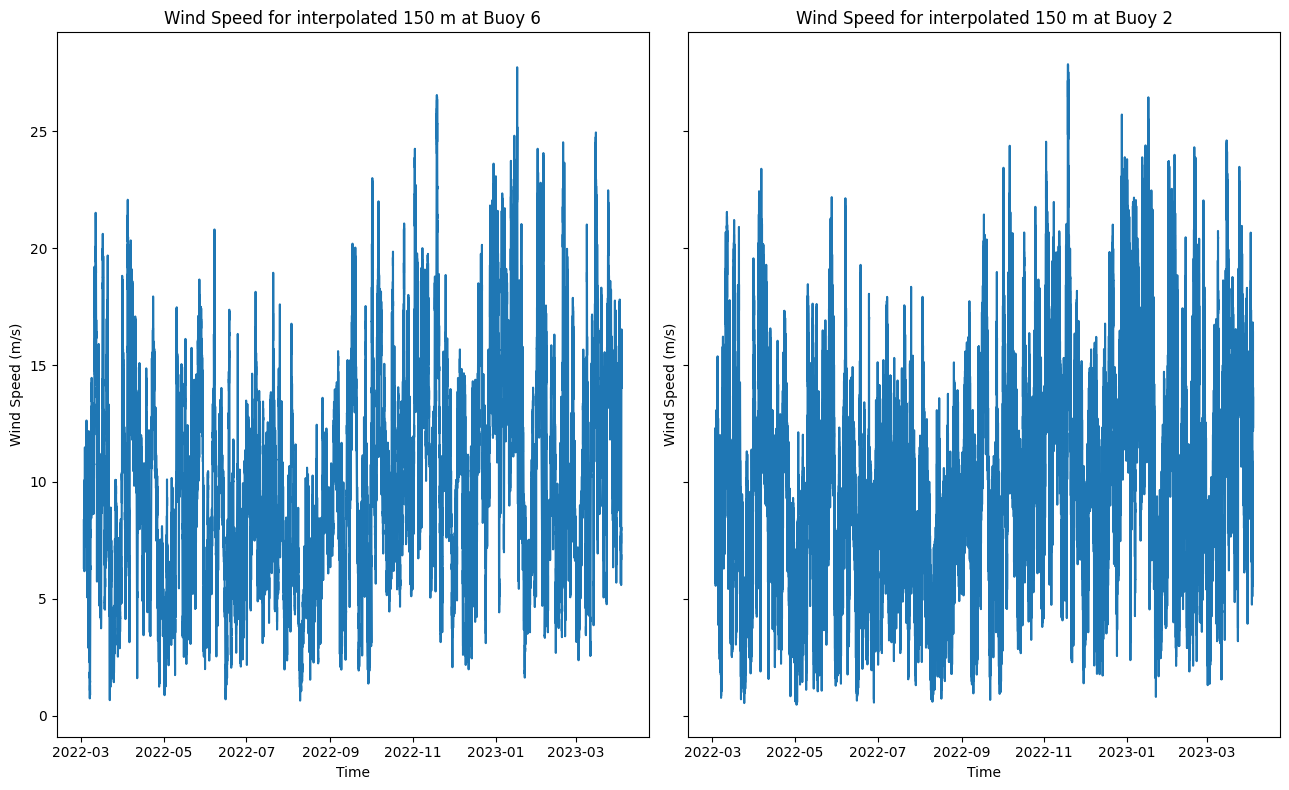

In [10]:
#Plotting processed data for buoy6 
fig, axes = plt.subplots(1, 2, figsize=(13, 8), sharey=True, sharex=True)

axes[0].plot(time6_filtered[4], ws6_150m)
axes[0].set_title('Wind Speed for interpolated 150 m at Buoy 6')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Wind Speed (m/s)')

axes[1].plot(time2_filtered[4], ws2_150m)
axes[1].set_title('Wind Speed for interpolated 150 m at Buoy 2')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Wind Speed (m/s)')


# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()

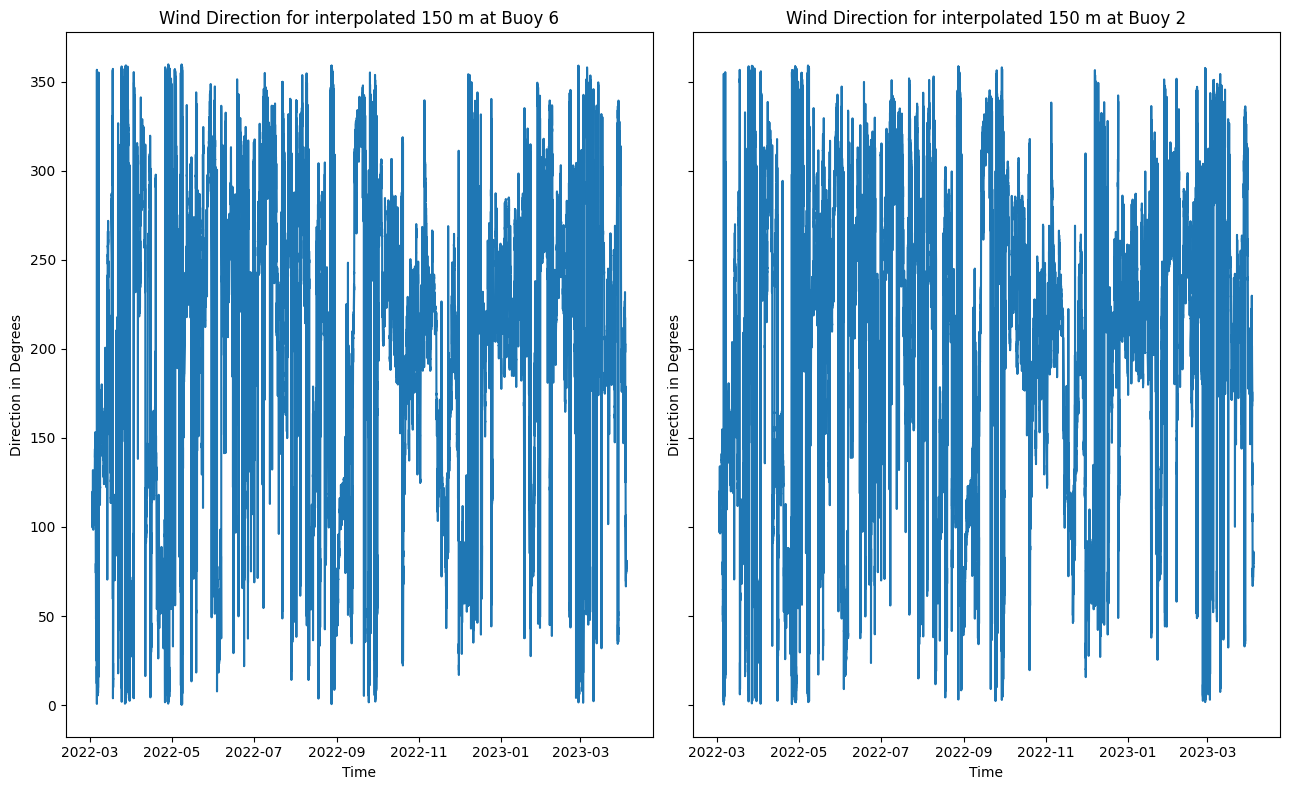

In [11]:
#Plotting processed data for buoy6 
fig, axes = plt.subplots(1, 2, figsize=(13, 8), sharey=True, sharex=True)

axes[0].plot(time6_filtered[4], wd6_150m)
axes[0].set_title('Wind Direction for interpolated 150 m at Buoy 6')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Direction in Degrees')

axes[1].plot(time2_filtered[4], wd2_150m)
axes[1].set_title('Wind Direction for interpolated 150 m at Buoy 2')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Direction in Degrees')


# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()

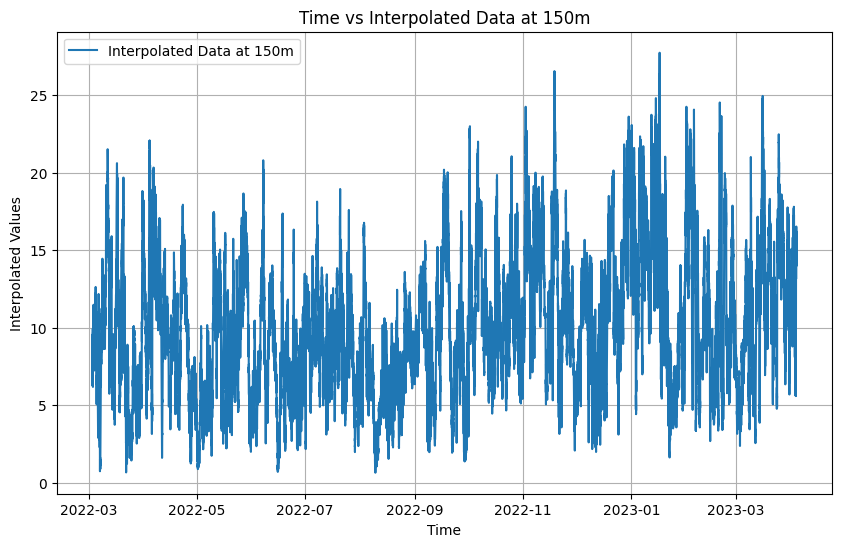

In [12]:
# Plotting time6 against ws_150m 
plt.figure(figsize=(10, 6))
plt.plot(time6_filtered[4], ws6_150m, label='Interpolated Data at 150m')
plt.xlabel('Time')
plt.ylabel('Interpolated Values')
plt.title('Time vs Interpolated Data at 150m')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression


def plot_scatter_with_regression(x, y, xlabel, ylabel, title):

    y_pred = model.predict(x_reshape)
    r2 = model.score(x_reshape, y)
    
    # Create scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, label='Data points')
    plt.plot(x, y_pred, color='red', label=f'Linear fit: $R^2$ = {r2:.2f}')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.show()

# Scatter plot for wind speed
plot_scatter_with_regression(ws6_150m, ws2_150m, 'ws6_150m', 'ws2_150m', 'Wind Speed Comparison at 150m')

# Scatter plot for wind direction
plot_scatter_with_regression(wd6_150m, wd2_150m, 'wd6_150m', 'wd2_150m', 'Wind Direction Comparison at 150m')


ModuleNotFoundError: No module named 'sklearn'